In [1]:
!pip install optuna
!pip install bayesian-optimization
!pip install scikit-optimize
!pip install hyperopt
!pip install scikit-optimize

In [97]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import time        
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Bayesian optimization libraries.
import optuna
# from hpsklearn import HyperoptEstimator, svc

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)    

/kaggle/input/playground-series-s4e6/sample_submission.csv
/kaggle/input/playground-series-s4e6/train.csv
/kaggle/input/playground-series-s4e6/test.csv


# 🥊 Battle of Bayesian Optimization Methods ⚔️

I always wondered how all the different hyperparameter tuning techniques differ. In this notebook I want to investigate this and try to understand which method is prefered in which situation. The methods we are going to compare are: 

- [Optuna](https://optuna.readthedocs.io/en/stable/index.html)
- [BayesianOptimization](https://github.com/bayesian-optimization/BayesianOptimization)
- [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)
- [hyperopt](https://github.com/hyperopt/hyperopt-sklearn)
- [gp_minimize](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html)

In [5]:
success = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
print(f"Rows: {success.shape[0]:,}")
print(f"Cols: {success.shape[1]:,}")
success.head(3)

Rows: 76,518
Cols: 38


,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout


In [8]:
success.dtypes

id                                                  int64
Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees u

In [15]:
# --- Global settings ---
RANDOM_STATE = 42

# EDA 

In [11]:
# --- Target distribution ---
100 * success['Target'].value_counts(normalize=True)

Target
Graduate    47.416294
Dropout     33.058888
Enrolled    19.524818
Name: proportion, dtype: float64

In [13]:
# --- Basic statistics ---
pd.DataFrame(
    {
        'Data Type': success.dtypes,
        'Missing Count (#)': success.isnull().sum(),
        'Unique Count (#)': success.nunique(),
        'Duplicates Count (#)': [success[c].duplicated().sum() for c in success.columns],
        'Missing Rate (%)': 100 * success.isnull().mean(),        
        'Unique Rate (%)': round(100 * success.nunique() / success.shape[0], 2),        
        'Duplicates Rate (%)': [round(100 * success[c].duplicated().sum() / success.shape[0], 2) for c in success.columns],
    }
)

,Data Type,Missing Count (#),Unique Count (#),Duplicates Count (#),Missing Rate (%),Unique Rate (%),Duplicates Rate (%)
id,int64,0,76518,0,0.0,100.00,0.00
Marital status,int64,0,6,76512,0.0,0.01,99.99
Application mode,int64,0,22,76496,0.0,0.03,99.97
Application order,int64,0,8,76510,0.0,0.01,99.99
Course,int64,0,19,76499,0.0,0.02,99.98
Daytime/evening attendance,int64,0,2,76516,0.0,0.00,100.00
Previous qualification,int64,0,21,76497,0.0,0.03,99.97
Previous qualification (grade),float64,0,110,76408,0.0,0.14,99.86
Nacionality,int64,0,18,76500,0.0,0.02,99.98
Mother's qualification,int64,0,35,76483,0.0,0.05,99.95


# Pre-Processing

In [14]:
# Encode the target variable.
label_encoder = LabelEncoder()
success['Target_bool'] = label_encoder.fit_transform(success['Target'])

In [23]:
selected_features = [
    'Marital status', 
    'Application mode', 
    'Application order', 
    'Course', 
    'Previous qualification', 
    'Mother\'s qualification', 
    'Father\'s qualification', 
    'Admission grade', 
    'Age at enrollment'
]

X = success[selected_features]
y = success['Target_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(f"""Shapes
    Train 
        X : {X_train.shape[0]:8,} (rows)  {X_train.shape[1]:4,} (cols)
        y : {y_train.shape[0]:8,} (rows)
    Test 
        X : {X_test.shape[0]:8,} (rows)  {X_test.shape[1]:4,} (cols)
        y : {y_test.shape[0]:8,} (rows)
""")

Shapes
    Train 
        X :   61,214 (rows)     9 (cols)
        y :   61,214 (rows)
    Test 
        X :   15,304 (rows)     9 (cols)
        y :   15,304 (rows)



In [37]:
# To save all the models results and the time it took.
RESULTS = {
    'Baseline': [],
    'Optuna': [], 
    'BayesianOptimization': [],
    'BayesSearchCV': [],
    'hyperopt': [],
    'gp_minimize': []
}

# Baseline Model

We need a baseline model to compare our optimized models against. This model will simply use the default parameters and not perform any hyperparameter optimization on them. 

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [91]:
# --- Train ---
start_time = time.time()

model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
RESULTS['Baseline'] = []
RESULTS['Baseline'].append(elapsed_time)

In [92]:
# --- Predict ---
y_pred = model.predict(X_test)

In [93]:
# --- Evaluate ---
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.60


In [94]:
RESULTS['Baseline'].append(accuracy)
RESULTS

{'Baseline': [10.535170316696167, 0.6047438578149503],
 'Optuna': [416.83157873153687, 0.6462362780972295],
 'BayesianOptimization': [384.6294755935669, 0.6463016204913749],
 'BayesSearchCV': [537.6978981494904, 0.6470857292211186],
 'hyperopt': [306.8856716156006, 0.6474124411918453],
 'gp_minimize': [446.1223113536835, 0.6470857292211186]}

# Optuna

In [45]:
import optuna
from sklearn.model_selection import cross_val_score

In [46]:
N_JOBS = -1
NUM_TRIALS = 50
NUM_PARALLEL_TRIALS = 4

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE
    )
    
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=N_JOBS)
    return score.mean()

pruner = optuna.pruners.MedianPruner()

In [47]:
# --- Optimize hyperparameters using Optuna ---
start_time = time.time()

study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=NUM_TRIALS, n_jobs=NUM_PARALLEL_TRIALS)

elapsed_time = time.time() - start_time
RESULTS['Optuna'].append(elapsed_time)

print(study.best_params)

[I 2024-08-29 12:16:09,510] A new study created in memory with name: no-name-6fc6386d-7d1b-4e1c-a924-c7eee0235e49
[I 2024-08-29 12:16:23,585] Trial 0 finished with value: 0.63601460815788 and parameters: {'n_estimators': 90, 'max_depth': 8, 'min_samples_split': 10}. Best is trial 0 with value: 0.63601460815788.
[I 2024-08-29 12:16:25,342] Trial 1 finished with value: 0.624236243450382 and parameters: {'n_estimators': 133, 'max_depth': 6, 'min_samples_split': 7}. Best is trial 0 with value: 0.63601460815788.
[I 2024-08-29 12:16:31,549] Trial 3 finished with value: 0.6362923194707936 and parameters: {'n_estimators': 75, 'max_depth': 8, 'min_samples_split': 3}. Best is trial 3 with value: 0.6362923194707936.
[I 2024-08-29 12:16:33,748] Trial 2 finished with value: 0.6467964746683681 and parameters: {'n_estimators': 137, 'max_depth': 12, 'min_samples_split': 7}. Best is trial 2 with value: 0.6467964746683681.
[I 2024-08-29 12:16:37,725] Trial 4 finished with value: 0.6479400180712909 and p

{'n_estimators': 66, 'max_depth': 13, 'min_samples_split': 10}


In [48]:
best_params = study.best_params

# Train final model with best hyperparameters.
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    n_jobs=-1,
    random_state=RANDOM_STATE
)

best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, min_samples_split=10, n_estimators=66,
                       n_jobs=-1, random_state=42)

In [49]:
y_pred = best_model.predict(X_test)

In [50]:
accuracy_optuna = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_optuna:.2f}')

Accuracy: 0.65


In [51]:
RESULTS['Optuna'].append(accuracy_optuna)
RESULTS

{'Baseline': [11.09047794342041],
 'Optuna': [416.83157873153687, 0.6462362780972295],
 'BayesianOptimization': [],
 'BayesSearchCV': [],
 'hyperopt': [],
 'gp_minimize': []}

# BayesianOptimization

In [57]:
from bayes_opt import BayesianOptimization

In [58]:
def objective_bayes(n_estimators, max_depth, min_samples_split):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return score.mean()

In [59]:
# Search space.
pbounds = {
    'n_estimators': (50, 200),
    'max_depth': (3, 20),
    'min_samples_split': (2, 10)
}

# Initialize.
optimizer = BayesianOptimization(
    f=objective_bayes,
    pbounds=pbounds,
    random_state=RANDOM_STATE
)

In [60]:
start_time = time.time()

optimizer.maximize(init_points=5, n_iter=45)  # init_points + n_iter = total iterations

elapsed_time = time.time() - start_time
RESULTS['BayesianOptimization'] = []
RESULTS['BayesianOptimization'].append(elapsed_time)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.6407    | 9.367     | 9.606     | 159.8     |
| 2         | 0.6452    | 13.18     | 3.248     | 73.4      |
| 3         | 0.5892    | 3.987     | 8.929     | 140.2     |
| 4         | 0.6435    | 15.04     | 2.165     | 195.5     |
| 5         | 0.638     | 17.15     | 3.699     | 77.27     |
| 6         | 0.6469    | 12.67     | 6.469     | 177.5     |
| 7         | 0.5887    | 3.276     | 2.118     | 54.4      |
| 8         | 0.5885    | 3.0       | 10.0      | 188.2     |
| 9         | 0.6471    | 12.7      | 7.23      | 169.1     |
| 10        | 0.6248    | 20.0      | 2.0       | 183.5     |
| 11        | 0.6047    | 4.379     | 2.0       | 169.4     |
| 12        | 0.6447    | 18.46     | 10.0      | 173.2     |
| 13        | 0.6447    | 19.61     | 10.0      | 162.2     |
| 14        | 0.5984    | 4.704     | 2.174     | 80.78     |
| 15    

In [61]:
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])

best_model_bayes = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    n_jobs=-1,
    random_state=RANDOM_STATE
)

best_model_bayes.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, min_samples_split=10, n_estimators=112,
                       n_jobs=-1, random_state=42)

In [62]:
y_pred_bayes = best_model_bayes.predict(X_test)

In [63]:
accuracy_bayes = accuracy_score(y_test, y_pred_bayes)
print(f'Accuracy: {accuracy_bayes:.2f}')

Accuracy: 0.65


In [64]:
RESULTS['BayesianOptimization'].append(accuracy_bayes)
RESULTS

{'Baseline': [11.09047794342041, 10.936943769454956, 0.6047438578149503],
 'Optuna': [416.83157873153687, 0.6462362780972295],
 'BayesianOptimization': [384.6294755935669, 0.6463016204913749],
 'BayesSearchCV': [],
 'hyperopt': [],
 'gp_minimize': []}

# BayesSearchCV

In [65]:
from skopt import BayesSearchCV

In [66]:
search_space = {
    'n_estimators': (50, 200),
    'max_depth': (3, 20),
    'min_samples_split': (2, 10),
}

# Initialize.
model = RandomForestClassifier(random_state=RANDOM_STATE)

# Set up..
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [67]:
start_time = time.time()

bayes_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time
RESULTS['BayesSearchCV'].append(elapsed_time)

In [68]:
best_params_bayessearch = bayes_search.best_params_
print(f'Best hyperparameters found by BayesSearchCV: {best_params_bayessearch}')

y_pred_bayessearch = bayes_search.predict(X_test)

Best hyperparameters found by BayesSearchCV: OrderedDict([('max_depth', 13), ('min_samples_split', 10), ('n_estimators', 200)])


In [69]:
accuracy_bayessearch = accuracy_score(y_test, y_pred_bayessearch)
print(f'Accuracy: {accuracy_bayessearch:.2f}')

Accuracy: 0.65


In [70]:
RESULTS['BayesSearchCV'].append(accuracy_bayessearch)
RESULTS

{'Baseline': [11.09047794342041, 10.936943769454956, 0.6047438578149503],
 'Optuna': [416.83157873153687, 0.6462362780972295],
 'BayesianOptimization': [384.6294755935669, 0.6463016204913749],
 'BayesSearchCV': [537.6978981494904, 0.6470857292211186],
 'hyperopt': [],
 'gp_minimize': []}

# hyperopt

In [74]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

In [75]:
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 20, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
}

def objective_hyperopt(params):
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1).mean()
    
    # Hyperopt minimizes the objective, so we return the negative accuracy.
    return {'loss': -score, 'status': STATUS_OK}

# To track results.
trials = Trials()

In [76]:
start_time = time.time()

best_params_hyperopt = fmin(
    fn=objective_hyperopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(RANDOM_STATE)
)

elapsed_time = time.time() - start_time
RESULTS['hyperopt'].append(elapsed_time)

100%|██████████| 50/50 [05:06<00:00,  6.14s/trial, best loss: -0.6477766474080552]


In [77]:
best_params_hyperopt['n_estimators'] = int(best_params_hyperopt['n_estimators'])
best_params_hyperopt['max_depth'] = int(best_params_hyperopt['max_depth'])
best_params_hyperopt['min_samples_split'] = int(best_params_hyperopt['min_samples_split'])

print(f'Best hyperparameters found by Hyperopt: {best_params_hyperopt}')

best_model_hyperopt = RandomForestClassifier(
    n_estimators=best_params_hyperopt['n_estimators'],
    max_depth=best_params_hyperopt['max_depth'],
    min_samples_split=best_params_hyperopt['min_samples_split'],
    n_jobs=-1,
    random_state=RANDOM_STATE
)

best_model_hyperopt.fit(X_train, y_train)

Best hyperparameters found by Hyperopt: {'max_depth': 13, 'min_samples_split': 8, 'n_estimators': 106}


RandomForestClassifier(max_depth=13, min_samples_split=8, n_estimators=106,
                       n_jobs=-1, random_state=42)

In [78]:
y_pred_hyperopt = best_model_hyperopt.predict(X_test)

In [79]:
accuracy_hyperopt = accuracy_score(y_test, y_pred_hyperopt)
print(f'Accuracy: {accuracy_hyperopt:.2f}')

Accuracy: 0.65


In [80]:
RESULTS['hyperopt'].append(accuracy_hyperopt)
RESULTS

{'Baseline': [11.09047794342041, 10.936943769454956, 0.6047438578149503],
 'Optuna': [416.83157873153687, 0.6462362780972295],
 'BayesianOptimization': [384.6294755935669, 0.6463016204913749],
 'BayesSearchCV': [537.6978981494904, 0.6470857292211186],
 'hyperopt': [306.8856716156006, 0.6474124411918453],
 'gp_minimize': []}

# gp_minimize

In [81]:
from skopt import gp_minimize
from skopt.space import Integer

In [82]:
search_space = [
    Integer(50, 200, name='n_estimators'),
    Integer(3, 20, name='max_depth'),
    Integer(2, 10, name='min_samples_split')
]

def objective_gp(params):
    n_estimators, max_depth, min_samples_split = params
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1).mean()
    
    # gp_minimize minimizes the objective, so we return the negative accuracy.
    return -score

In [83]:
start_time = time.time()

result = gp_minimize(
    func=objective_gp,
    dimensions=search_space,
    n_calls=50,              # Number of evaluations.
    random_state=RANDOM_STATE
)

elapsed_time = time.time() - start_time
RESULTS['gp_minimize'] = []
RESULTS['gp_minimize'].append(elapsed_time)

In [84]:
best_params_gp = {
    'n_estimators': result.x[0],
    'max_depth': result.x[1],
    'min_samples_split': result.x[2]
}

print(f'Best hyperparameters found by gp_minimize: {best_params_gp}')

best_model_gp = RandomForestClassifier(
    n_estimators=best_params_gp['n_estimators'],
    max_depth=best_params_gp['max_depth'],
    min_samples_split=best_params_gp['min_samples_split'],
    n_jobs=-1,
    random_state=RANDOM_STATE
)

Best hyperparameters found by gp_minimize: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 10}


In [85]:
best_model_gp.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, min_samples_split=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [86]:
y_pred_gp = best_model_gp.predict(X_test)

In [87]:
accuracy_gp = accuracy_score(y_test, y_pred_gp)
print(f'Accuracy: {accuracy_gp:.4f}')

Accuracy: 0.6471


In [88]:
RESULTS['gp_minimize'].append(accuracy_gp)
RESULTS

{'Baseline': [11.09047794342041, 10.936943769454956, 0.6047438578149503],
 'Optuna': [416.83157873153687, 0.6462362780972295],
 'BayesianOptimization': [384.6294755935669, 0.6463016204913749],
 'BayesSearchCV': [537.6978981494904, 0.6470857292211186],
 'hyperopt': [306.8856716156006, 0.6474124411918453],
 'gp_minimize': [446.1223113536835, 0.6470857292211186]}

# Performance Summary

In [95]:
summary = pd.DataFrame.from_dict(RESULTS, orient='index', columns=['Elapsed Time', 'Accuracy'])
summary

,Elapsed Time,Accuracy
Baseline,10.535170,0.604744
Optuna,416.831579,0.646236
BayesianOptimization,384.629476,0.646302
BayesSearchCV,537.697898,0.647086
hyperopt,306.885672,0.647412
gp_minimize,446.122311,0.647086


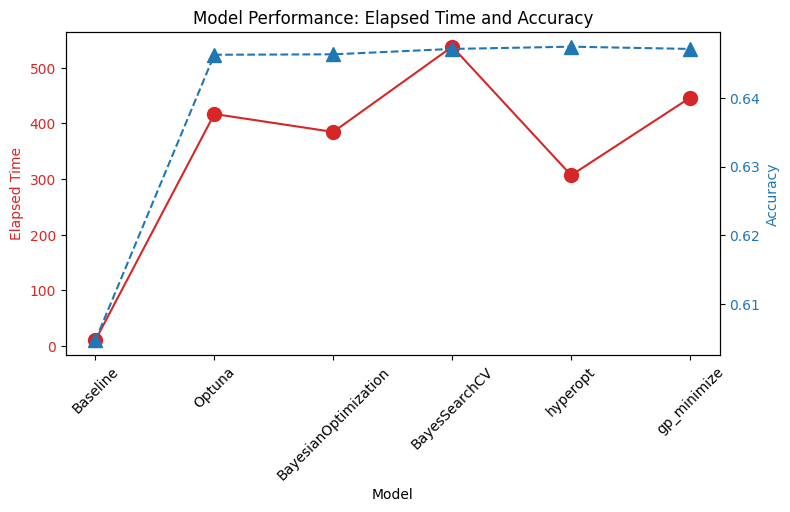

In [117]:
summary = pd.DataFrame.from_dict(RESULTS, orient='index', columns=['Elapsed Time', 'Accuracy']).reset_index().rename(columns={'index': 'Model'})

fig, ax1 = plt.subplots(figsize=(8, 5))

# --- Elapsed Time ---
ax1.set_xlabel('Model')
ax1.set_ylabel('Elapsed Time', color='tab:red')
ax1.plot(summary['Model'], summary['Elapsed Time'], color='tab:red', marker='o', markersize=10, linestyle='-', label='Elapsed Time')
ax1.tick_params(axis='y', labelcolor='tab:red')

plt.xticks(rotation=45)

# --- Accuracy ---
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(summary['Model'], summary['Accuracy'], color='tab:blue', marker='^', markersize=10, linestyle='--', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title('Model Performance: Elapsed Time and Accuracy')
plt.show()

---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏